In [9]:
ls


class_dict.csv  test/  train/  valid/


In [8]:
cd drive/MyDrive/315_Birds_Species/

/content/drive/MyDrive/315_Birds_Species


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
import os
import numpy as np
import shutil
import random
from keras import models, layers

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input
import keras

decode_predictions = keras.applications.vgg16.decode_predictions
import numpy as np
from numpy import expand_dims
from skimage.transform import resize
import matplotlib.pyplot as plt

In [18]:
class VGG:
    def __init__(self, input_shape, output_classes):
        self.model    = self.getModel(input_shape, output_classes)
    def getModel(self,input_shape,output_classes):
      vgg16 = VGG16(include_top=False, classes=output_classes, weights='imagenet', input_shape=input_shape)
      self.vgg  = vgg16
      for layer in vgg16.layers:
        layer.trainable = False
      print(vgg16.summary())
      self.vgg = vgg16
      model = models.Sequential()
      model.add(vgg16)
      model.add(layers.Flatten())
      model.add(layers.Dense(512, activation="relu"))
      model.add(layers.Dense(128, activation="relu"))
      model.add(layers.Dense(output_classes, activation="softmax"))
      print("-------------------------------")
      print("-------------------------------")
      print("Model Summary")
      print("-------------------------------")
      print("-------------------------------")
      print(model.summary())
      return model

    def getTainAugmentation(self,train_data_dir,target_size=(224, 224),batch_size=32):
        train_generator = ImageDataGenerator(
                                          rescale=1./255,
                                          rotation_range=50, 
                                          width_shift_range=0.2, 
                                          height_shift_range=0.2,
                                          horizontal_flip=True, 
                                          fill_mode = 'nearest'
                                          ) 
        traingen = train_generator.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=target_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size, 
                                                    shuffle=True,
                                                    seed=42)
        return traingen
  
    def getTestAugmentation(self,test_data_dir,target_size=(224, 224),batch_size=32):
      test_datagen = ImageDataGenerator(rescale=1./255)
      testngen = test_datagen.flow_from_directory(
                                                  test_data_dir,
                                                  target_size= target_size,
                                                  class_mode= 'categorical',
                                                  batch_size= batch_size, 
                                                  shuffle=True,
                                                  seed=42)
      return testngen

    def getValidationAugmentation(self,validation_data_dir,target_size=(224, 224),batch_size=32):
      validation_datagen = ImageDataGenerator(rescale=1./255)
      validationgen = validation_datagen.flow_from_directory(
                                                  validation_data_dir,
                                                  target_size=target_size,
                                                  class_mode='categorical',
                                                  batch_size=batch_size, 
                                                  shuffle=True,
                                                  seed=42)
      return validationgen


    def train(self,train_data_dir,validation_data_dir,target_size,batch_size,epochs):
      traingen = self.getTainAugmentation(train_data_dir,target_size,batch_size)
      validationgen = self.getValidationAugmentation(validation_data_dir,target_size,batch_size)
      self.model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
       )
      history = self.model.fit(
        traingen,
        steps_per_epoch=  len(traingen),
        epochs=epochs,
        validation_data=validationgen,
        validation_steps= len(validationgen))
      return history 
    def plot_accuracy(self,history):
        fig1 = plt.gcf()
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.axis(ymin=0.4,ymax=1)
        plt.grid()
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'validation'])
        plt.show(self,history) 
    def  plot_loss(self,history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid()
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'validation'])
        plt.show()
    def test_model(self, test):  
       test_accu = self.model.evaluate(test)
       print('Testing accuracy:',test_accu[1]*100, '%')
    def predict(self, img_array):
      return self.model.predict(img_array)


    def get_img_array(self,img_path, size):
        img = keras.preprocessing.image.load_img(img_path, target_size=size)
        array = keras.preprocessing.image.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array
    def make_gradcam_heatmap(self,img_array, model, last_conv_layer_name, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        
        grad_model = tf.keras.models.Model(
            [model.inputs], [self.vgg.get_layer(last_conv_layer_name).output, model.output]
        )
        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

In [19]:
vgg = VGG((224, 224,3),315)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

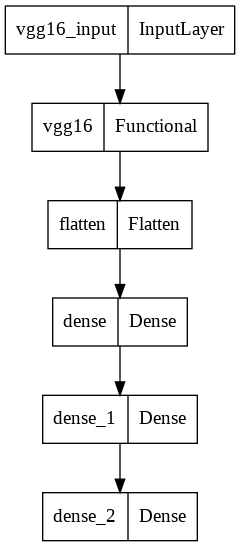

In [5]:
#Architecture
import pydot
plot_model(vgg.model)

In [ ]:
train_data_dir = "./train"
validation_data_dir = "./valid"
target_size = (224,224)
batch_size = 32
epochs = 10
history = vgg.train(train_data_dir,validation_data_dir,target_size,batch_size,epochs)

Found 36514 images belonging to 315 classes.
Found 0 images belonging to 315 classes.
Epoch 1/10
 208/1142 [====>.........................] - ETA: 4:28:36 - loss: 5.7623 - accuracy: 0.0038